# PVDAQ - PVData¶

This notebook is an example about how to access the PVdata and related metadata through OEDI data lake.

## 0. Prerequisites

To run this example, it requires you have OEDI data lake deployed, where all quries run through. About how to deploy OEDI data lake, please refer to the documentation here - https://openedi.github.io/open-data-access-tools/.

In this example, the deployed database is `oedi_data_lake`, where the tables related to pvdata are named:
  * `pvdaq_inverters`
  * `pvdaq_meters`
  * `pvdaq_metrics`
  * `pvdaq_modules`
  * `pvdaq_mount`
  * `pvdaq_other_instruments`
  * `pvdaq_pvdata`
  * `pvdaq_site`
  * `pvdaq_system`

The staging location for queries is `s3://nrel-tests/pvdaq/`.

In [1]:
# database
database_name = "oedi_pvdaq_staging"

# tables
pvdaq_inverters_table = "pvdaq_inverters"
pvdaq_meters_table = "pvdaq_meters"
pvdaq_metrics_table = "pvdaq_metrics"
pvdaq_modules_table = "pvdaq_modules"
pvdaq_mount_table = "pvdaq_mount"
pvdaq_other_instruments_table = "pvdaq_other_instruments"
pvdaq_pvdata_table = "pvdaq_pvdata"
pvdaq_site_table = "pvdaq_site"
pvdaq_system_table = "pvdaq_system"

staging_location = "s3://nrel-jgu2/pvdaq/"

## 1. Metadata

The metadata of pvdaq tables include 'Columns', 'Partition Keys' and 'Partition Values'. OEDIGlue class provides utility methods to retrieve the metadata from a given table.

In [2]:
from oedi.AWS.glue import OEDIGlue

In [3]:
glue = OEDIGlue()

In [6]:
# PVDAQ Site Table
glue.get_table_columns(database_name, pvdaq_site_table)

,Name,Type
0,av_pressure,string
1,av_temp,string
2,climate_type,string
3,elevation,string
4,latitude,string
5,location,string
6,longitude,string
7,public_name,string
8,site_id,string
9,system_id,bigint


In [7]:
# PVDAQ System Table
glue.get_table_columns(database_name, pvdaq_system_table)

,Name,Type
0,area,string
1,comments,string
2,ended_on,string
3,power,string
4,public_name,string
5,site_id,bigint
6,started_on,string
7,system_id,bigint


In [8]:
# PVDAQ Metrics Table
glue.get_table_columns(database_name, pvdaq_metrics_table)

,Name,Type
0,system_id,int
1,metric_id,int
2,sensor_name,string
3,common_name,string
4,raw_units,string
5,units,string
6,calc_scale,double
7,calc_offset,double
8,calc_details,string
9,aggregation_type,string


In [9]:
# PVDAQ PVDATA Table
glue.get_table_columns(database_name, pvdaq_pvdata_table)

,Name,Type
0,measured_on,timestamp
1,utc_measured_on,timestamp
2,metric_id,int
3,value,double


## 2. PV System Locations
Visualize the locations of PV systems on the map

In [10]:
import pandas as pd
from oedi.AWS.athena import OEDIAthena

In [11]:
athena = OEDIAthena(staging_location=staging_location, region_name="us-west-2")

In [13]:
query_string1 = f"""
    SELECT system.public_name, site.latitude, site.longitude 
    FROM {database_name}.{pvdaq_system_table} AS system 
    INNER JOIN {database_name}.{pvdaq_site_table} AS site 
    ON cast(system.site_id as varchar)=site.site_id;
"""
systems = athena.run_query(query_string1)

In [14]:
systems[["latitude", "longitude"]] = systems[["latitude", "longitude"]].apply(pd.to_numeric)

In [15]:
import folium
imap = folium.Map(location=[32.53056, -89.01959696969696], zoom_start=5, tiles="Stamen Terrain")

In [16]:
for index, row in systems.iterrows():
    folium.Marker(
        location=[row.latitude, row.longitude],
        fill_color="#43d9de",
        radius=8,
        popup=f"<i>{row.public_name}</i>", tooltip="Click Me"
    ).add_to(imap)
imap

## 3. PV System metrics

In [17]:
query_string2 = f"""
    select pvdata.measured_on, pvdata.value, metrics.common_name, metrics.system_id 
    from {database_name}.{pvdaq_pvdata_table} as pvdata
    inner join {database_name}.{pvdaq_metrics_table} as metrics
    on pvdata.metric_id=metrics.metric_id
    where metrics.system_id=1230 
    AND year='2006';
"""

In [18]:
pvdata = athena.run_query(query_string2)

In [19]:
pvdata.head()

,measured_on,value,common_name,system_id
0,2006-06-08 00:00:00,56.4,Temperature ambient,1230
1,2006-06-08 00:15:00,0.0,DC power,1230
2,2006-06-08 00:30:00,56.1,Temperature ambient,1230
3,2006-06-08 00:45:00,0.0,Irradiance POA,1230
4,2006-06-08 00:45:00,80.0,Humidity,1230


In [20]:
pvdata["common_name"].unique()

array(['Temperature ambient', 'DC power', 'Irradiance POA', 'Humidity'],
      dtype=object)

In [23]:
df = pd.DataFrame()
for column in sorted(pvdata["common_name"].unique()):
    sub = pvdata[pvdata["common_name"] == column]
    sub = sub.set_index("measured_on")
    column = column.lower().replace(" ", "_")
    sub = sub.drop(columns=["common_name", "system_id"])
    sub = sub.rename(columns={"value": column})
    if df.empty:
        df = sub
    else:
        df = df.join(sub, on="measured_on")
df.head()

,dc_power,humidity,irradiance_poa,temperature_ambient
measured_on,,,,
2006-06-08 00:15:00,0.0,78.9,0.0,56.3
2006-06-08 00:15:00,0.0,78.9,0.0,55.9
2006-06-08 01:15:00,0.0,81.0,0.0,55.8
2006-06-08 01:15:00,0.0,81.0,0.0,55.4
2006-06-08 02:15:00,0.0,82.7,0.0,55.4


array([<AxesSubplot:xlabel='measured_on', ylabel='unit: W'>,
       <AxesSubplot:xlabel='measured_on', ylabel='unit: %'>,
       <AxesSubplot:xlabel='measured_on', ylabel='unit: W/m^2'>,
       <AxesSubplot:xlabel='measured_on', ylabel='unit: C'>], dtype=object)

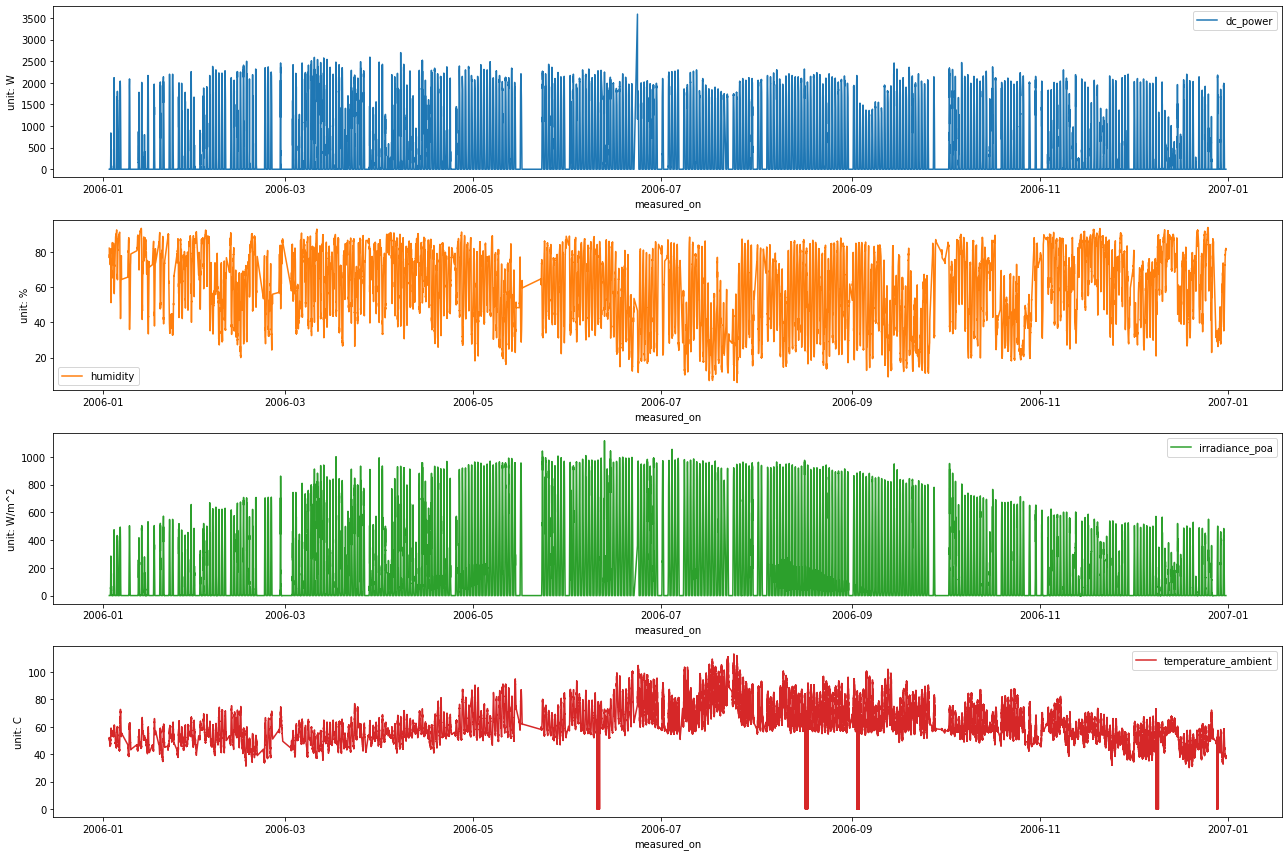

In [26]:
import matplotlib.pyplot as plt
_, a = plt.subplots(4, 1, figsize=(18, 12), tight_layout=True)
a[0].set_ylabel("unit: W")
a[1].set_ylabel("unit: %")
a[2].set_ylabel("unit: W/m^2")
a[3].set_ylabel("unit: C")
df.plot(ax=a, subplots=True)